In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.1 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx + tf.broadcast_to(np.pi ** 2, tf.shape(tf.sin(np.pi * x))) * tf.sin(np.pi * x)


In [ ]:
def boundary(x, on_boundary):
    return on_boundary

def boundary_func(x):
    return 0

In [ ]:
def exact_sol(x):
  return np.sin(np.pi * x)

In [ ]:
bc = dde.icbc.DirichletBC(geom, boundary_func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=exact_sol, num_test=100)


In [ ]:
layer_size = [1] + [30] * 10 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)


In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=1900)

Compiling model...
'compile' took 1.181748 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.59e+01, 6.71e-02]    [5.19e+01, 6.71e-02]    [1.20e+00]    
1000      [3.54e-03, 2.88e-04]    [1.81e-03, 2.88e-04]    [1.50e-02]    
1900      [4.33e-03, 2.59e-04]    [2.03e-03, 2.59e-04]    [1.40e-02]    

Best model at step 1000:
  train loss: 3.82e-03
  test loss: 2.10e-03
  test metric: [1.50e-02]

'train' took 7.679308 s



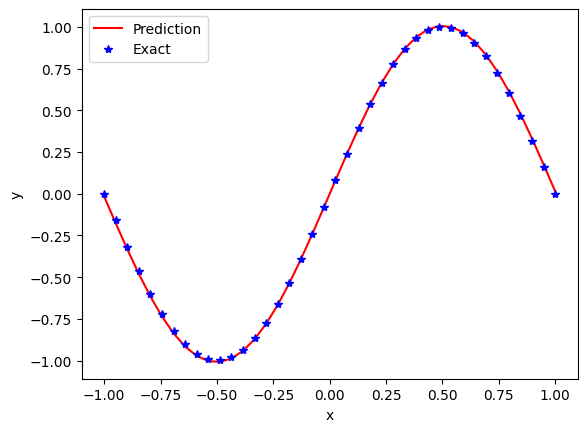

In [ ]:
x = geom.uniform_points(40, True)
y_pred = model.predict(x)
y_exact = exact_sol(x)
plt.figure()
plt.plot(x, y_pred, label="Prediction", color='r')
plt.plot(x, y_exact, '*', label="Exact", color='b')
plt.legend(loc='best')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Heat Equation using Deepxde

In [ ]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np

In [ ]:
a = 0.4
L = 1
n = 1

In [ ]:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, n)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx

In [ ]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 2*x[:, 0:1], lambda _, on_boundary: on_boundary)

ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)

In [ ]:
net = dde.nn.FNN([2] + [20] * 8 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.140303 s

'compile' took 1.412861 s



In [ ]:
losshistory, train_state = model.train(iterations=15000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.60e-01, 1.85e+00, 8.43e-01]    [6.43e-01, 1.85e+00, 8.43e-01]    []  
1000      [5.07e-03, 6.04e-02, 1.32e-01]    [4.00e-03, 6.04e-02, 1.32e-01]    []  
2000      [1.32e-02, 3.37e-02, 7.34e-02]    [6.57e-03, 3.37e-02, 7.34e-02]    []  
3000      [5.54e-03, 2.71e-02, 1.44e-02]    [4.16e-03, 2.71e-02, 1.44e-02]    []  
4000      [4.02e-03, 1.88e-02, 9.07e-03]    [2.92e-03, 1.88e-02, 9.07e-03]    []  
5000      [3.23e-03, 1.33e-02, 6.48e-03]    [2.50e-03, 1.33e-02, 6.48e-03]    []  
6000      [2.86e-03, 9.42e-03, 5.30e-03]    [2.19e-03, 9.42e-03, 5.30e-03]    []  
7000      [2.39e-03, 6.95e-03, 4.37e-03]    [1.71e-03, 6.95e-03, 4.37e-03]    []  
8000      [1.87e-03, 5.05e-03, 3.75e-03]    [1.44e-03, 5.05e-03, 3.75e-03]    []  
9000      [1.62e-03, 3.94e-03, 3.17e-03]    [1.31e-03, 3.94e-03, 3.17e-03]    []  
10000     [9.35e-03, 3.36e-03, 3.26e-03]    [3.82e-03, 3.36e-

In [ ]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.798041 s

Training model...

Step      Train loss                        Test loss                         Test metric
15000     [3.32e-03, 1.32e-03, 1.16e-03]    [3.44e-03, 1.32e-03, 1.16e-03]    []  
15017     [3.32e-03, 1.32e-03, 1.16e-03]    [3.44e-03, 1.32e-03, 1.16e-03]    []  

Best model at step 13000:
  train loss: 4.14e-03
  test loss: 5.02e-03
  test metric: []

'train' took 3.691889 s



Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


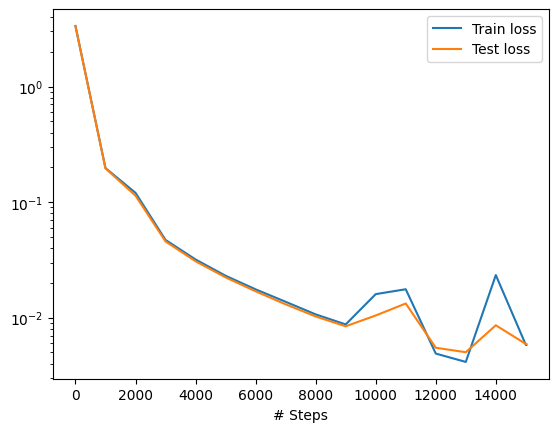

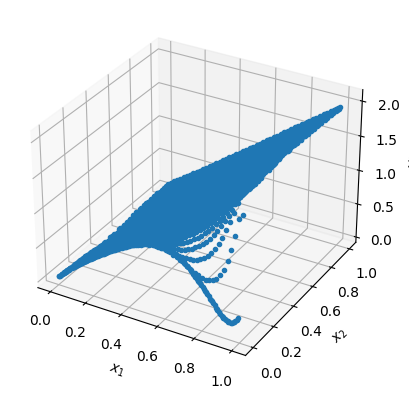

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)